# Trial for own CNN w/ pixel-targeting


based on Base_Model_01.ipynb
----


In [1]:
import random
import numpy as np

import json
import matplotlib.pyplot as plt
from tqdm import tqdm as tq

import tensorflow as tf
from keras import models, layers, optimizers, losses, metrics
from keras.utils import load_img
from keras.utils import img_to_array

2022-06-09 00:01:52.518305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-09 00:01:52.518333: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


-------------------------
# Import data

----


## Loading the Image

In [2]:
# Data sources
path_raw_data = 'Potsdam_v02_small/'
name_raw_data = 'Potsdam02s'
raw_image_number = 0
tile_size = 30 # in pixel
batch_size = 300

## Loading the label-points for the picture from label studio

There are (1383,) labeled trees in the picture


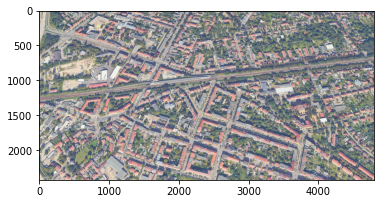

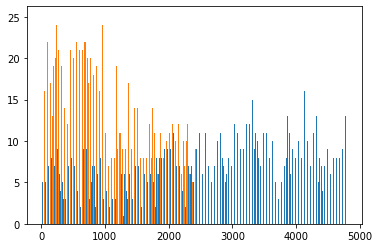

The image size is 4800x2427 pixels.
The 1383 data points are distributed along the respective axis as follows:


In [3]:
def import_image(path_raw_data, name_raw_data, raw_image_number):

    # load the image to get its shape
    orig_image = load_img(path_raw_data+name_raw_data+'.jpg')
    i_width, i_height = orig_image.size

    # convert to numpy array
    image = img_to_array(orig_image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0

    # load the label-points for the picture from label studio
    with open(path_raw_data+name_raw_data+'.json') as json_file:
        json_load = json.load(json_file)

    # select data
    json_load = json_load[raw_image_number]["annotations"][0]["result"]
    labels_x = ([])
    labels_y = ([])
    for i in json_load:
            labels_x = np.append(labels_x, i["value"]["x"])
            labels_y = np.append(labels_y, i["value"]["y"])
    labels_unscaled = np.vstack((labels_x, labels_y)).transpose()

    # scale data points to image pixels
    reshaper = [[(i_width/100), 0], [0,(i_height/100)]]
    labels = np.mat(labels_unscaled) * np.mat(reshaper)
    print(f"There are {labels_unscaled[:,0].shape} labeled trees in the picture")

    # show image
    plt.imshow(orig_image)
    plt.show()
    plt.close()
    # check label distribution in histogram
    plt.hist(labels, bins=200)
    plt.show()
    print(f"The image size is {i_width}x{i_height} pixels.")
    print(f"The {len(labels_x)} data points are distributed along the respective axis as follows:")

    return image, labels, orig_image, labels_unscaled, i_width, i_height

image, labels, orig_image, labels_unscaled, i_width, i_height = import_image(path_raw_data, name_raw_data, raw_image_number)

Matching Image and labels and show upload result

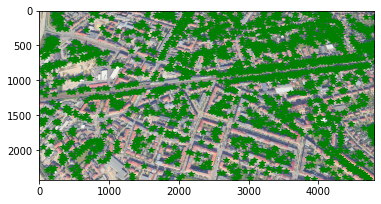

In [4]:
def show_img_with_labels(image=orig_image, labels=labels):
    plt.imshow(image)
    # plot each labeled tree
    for dot in labels:
        #print(dot[:,1])
        plt.plot(dot[:,0], dot[:,1], marker='*', color="green")
    # show the plot
    plt.show()

show_img_with_labels()

## Prepare tiles

Tiles = child-pictures of image, all together represent the whole image
- split the picture into quadratic tiles of equal size

In [5]:
def make_tiles(image=image, i_width=i_width, i_height=i_height, tile_size=tile_size):
    # define the tiles
    num_hor_tiles = i_width // tile_size
    num_ver_tiles = i_height // tile_size
    num_tiles = num_hor_tiles * num_ver_tiles
    print(f"There are {num_tiles} tiles at {tile_size}x{tile_size} pixels")
    print(f"There are {num_hor_tiles} horizontal tile columns and {num_ver_tiles} vertical tile rows")

    # prepare variables for the tiles
    image = np.array(image) # input image
    tiles = np.zeros((num_tiles, tile_size, tile_size, 3)) # all tile images
    tile_info_initial = np.zeros((num_tiles, 6)) # (tile row, tile column, true_label, probability, x_mean, y_mean)

    # create tiles
    for i in tq(range(num_ver_tiles)):
        for j in range(num_hor_tiles):
            tile_num = i * num_hor_tiles + j
            # give starting (left/top) & mean pixels in rows and columns for this tile
            v_start = i * tile_size
            h_start = j * tile_size
            v_mean = v_start + tile_size // 2
            h_mean = h_start + tile_size // 2
            # create tile
            tile = image[v_start:v_start+tile_size, h_start:h_start+tile_size, :]
            # add tile to array
            tiles[tile_num] = tile
            # store location ot tiles:
            tile_info_initial[tile_num] = (i,j,0,0,v_mean, h_mean)

    print(f"Tiles are created: {tiles.shape}.")
    return tiles, tile_info_initial, num_hor_tiles, num_ver_tiles

tiles, tile_info_initial, num_hor_tiles, num_ver_tiles = make_tiles()

There are 12800 tiles at 30x30 pixels
There are 160 horizontal tile columns and 80 vertical tile rows


100%|██████████| 80/80 [00:00<00:00, 560.38it/s]

Tiles are created: (12800, 30, 30, 3).


Labels vector is created over all tiles: (12800, 1).
Tiles labeled as with tree: 1360.0
This is 10.625% of the tiles.
Total trees assigned: 1383.0.
The max number of trees per tile is: 2.0
Distribution trees per tile:


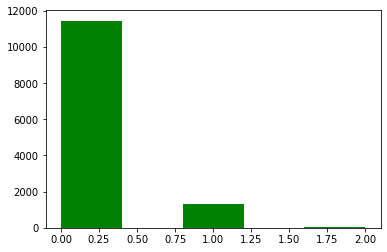

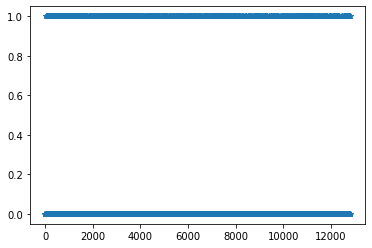

In [6]:
def label_tiles(labels=labels, tile_info_initial=tile_info_initial, tile_size=tile_size):
    num_tiles = tile_info_initial.shape[0]
    num_horizontal_tiles = tile_info_initial[:,1].max()  # number of horizontal tiles

    # Labeling the tiles
    tile_labels = np.zeros((num_tiles, 1)) # labels for each tile: 0 = no tree, 1 = tree
    tile_dense = np.zeros((num_tiles, 1)) # number of trees in each tile = density of a tile

    for label in labels:
        pos_horizontal = label[:,0] // tile_size -1 # tile column
        pos_vertical = label[:,1] // tile_size -1 # tile row
        tile_num = int(pos_vertical * (num_horizontal_tiles + 1) + pos_horizontal)
        tile_labels[tile_num] = 1
        tile_dense[tile_num] += 1
        tile_info = tile_info_initial
        tile_info[tile_num][2] = 1

    # print info on input labels
    print(f"Labels vector is created over all tiles: {tile_labels.shape}.")
    print(f"Tiles labeled as with tree: {tile_labels.sum()}")
    print(f"This is {tile_labels.sum()/tile_labels.shape[0]*100}% of the tiles.")
    print(f"Total trees assigned: {tile_dense.sum()}.")

    # show label distribution amongst tiles
    print(f"The max number of trees per tile is: {tile_dense.max()}")
    plt.hist(tile_dense, bins=5, color="green")
    print("Distribution trees per tile:")
    plt.show()
    plt.close()
    # check label distribution in histogram
    plt.plot(tile_info[:,2], '*')
    plt.show()

    return tile_info, tile_labels

tile_info, tile_labels = label_tiles()

(80, 160)


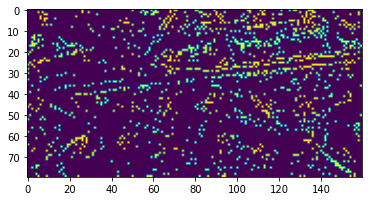

In [7]:
def show_true_tiles(tile_info=tile_info):
    # show labeled tiles
    num_ver = int(tile_info[:,0].max()) + 1
    num_hor = int(tile_info[:,1].max()) + 1
    tiles_show = tile_info[:,2].reshape(num_ver, num_hor)
    plt.imshow(tiles_show)
    print(tile_info[:,2].reshape(num_ver, num_hor).shape)

show_true_tiles()

tile_num is: 380
column: 60 of 160, row: 2 of 80
Tile label: 1.0
Tile prediction: 0.0


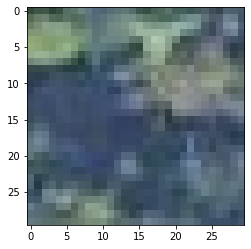

In [8]:
def show_example_tile(tile_info=tile_info):
    num_ver = int(tile_info[:,0].max()) + 1
    num_hor = int(tile_info[:,1].max()) + 1
    num_tiles = num_hor * num_ver
    example = random.randint(0, num_tiles-1)
    print(f"tile_num is: {example}")
    print(f"column: {example % num_hor} of {num_hor}, row: {example // num_hor} of {num_ver}")
    print(f"Tile label: {tile_info[example,2]}")
    print(f"Tile prediction: {tile_info[example,3]}")
    plt.imshow(tiles[example])
    plt.show()

show_example_tile()

## Prepare training and validation set

In [9]:
def make_train_set(tiles=tiles, tile_labels=tile_labels, tile_size=tile_size, batch_size=batch_size):
    # define the training set
    train_ratio = 0.8
    num_tiles = tiles.shape[0]
    num_train_tiles = int(num_tiles * train_ratio)
    num_val_tiles = num_tiles - num_train_tiles
    print(f"There are {num_tiles} tiles in total.")
    print(f"There are {num_train_tiles} tiles in the training set.")
    print(f"There are {num_val_tiles} tiles in the validation set.")

    # split into training and validation set
    train_tiles = tiles[:int(num_tiles*train_ratio)]
    train_labels = tile_labels[:int(num_tiles*train_ratio)]
    val_tiles = tiles[int(num_tiles*train_ratio):]
    val_labels = tile_labels[int(num_tiles*train_ratio):]
    print(f"Training set: {train_tiles.shape} - ({train_ratio} share of all tiles)")
    print(f"Validation set: {val_tiles.shape}")

    # build tensorflow dataset
    dataset_train_original = tf.data.Dataset.from_tensor_slices((train_tiles, train_labels))
    dataset_validate_original = tf.data.Dataset.from_tensor_slices((val_tiles, val_labels))

    # shuffle and batch
    def encode(tile, label):
        image_encoded = tf.image.convert_image_dtype(tile, dtype=tf.float32)
        image_encoded = tf.image.resize(image_encoded, (tile_size, tile_size))
        return image_encoded, label

    dataset_train = dataset_train_original.map(lambda image, label: encode(image, label)).cache().shuffle(25).batch(batch_size)
    dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label)).cache().batch(batch_size)

    return dataset_train, dataset_validate

dataset_train, dataset_validate = make_train_set()

There are 12800 tiles in total.
There are 10240 tiles in the training set.
There are 2560 tiles in the validation set.
Training set: (10240, 30, 30, 3) - (0.8 share of all tiles)
Validation set: (2560, 30, 30, 3)


2022-06-09 00:01:58.371402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-09 00:01:58.371425: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-09 00:01:58.371441: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Luise): /proc/driver/nvidia/version does not exist
2022-06-09 00:01:58.371656: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


-------
# Training

----



## model


In [43]:
def make_model_base(tile_size=tile_size):

    METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'),
      #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      #tf.keras.metrics.AUC(name='auc'),
      #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

    model = models.Sequential()
    initializer = tf.keras.initializers.GlorotUniform(seed=42)

    model.add(layers.Input(shape=(tile_size, tile_size, 3)))

    model.add(layers.Conv2D(20, (3,3), activation="relu", padding="same"))
    model.add(layers.Conv2D(30, (3,3), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(150, activation="relu"))
    model.add(layers.Dense(20, activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))



    model.summary()
    return model, METRICS

model, METRICS = make_model_base()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 20)        560       
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 30)        5430      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 30)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 6750)              0         
                                                                 
 dense_6 (Dense)             (None, 150)               1012650   
                                                                 
 dense_7 (Dense)             (None, 20)                3020      
                                                      

## Train a model

In [45]:
def train_model(model_name="latest", model=model, dataset_train=dataset_train, dataset_validate=dataset_validate, epochs=15, metrics=METRICS):

    model.compile(
        loss='binary_crossentropy',
        optimizer="adam",
        metrics=metrics,
    )
    history = model.fit(
        dataset_train,
        epochs=epochs,
        validation_data=dataset_validate,
    )
    model.save(model_name)
    return model, history, model_name

model, history, model_name = train_model(model_name="model_base")

Epoch 1/15
35/35 [==============================] - 8s 210ms/step - loss: 0.3215 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2521 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
35/35 [==============================] - 7s 194ms/step - loss: 0.3180 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2537 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
35/35 [==============================] - 6s 184ms/step - loss: 0.3164 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2522 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/15
35/35 [==============================] - 6s 182ms/step - loss: 0.3142 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2532 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/15
35/35 [==============================] - 6s 182ms/step - loss: 0.3103 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2545 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/15

INFO:tensorflow:Assets written to: model_base/assets


INFO:tensorflow:Assets written to: model_base/assets


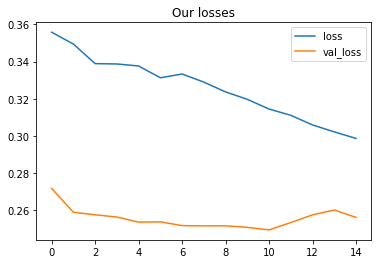

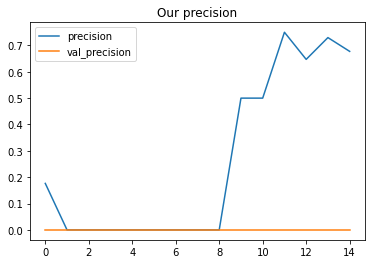

TypeError: unhashable type: 'dict'

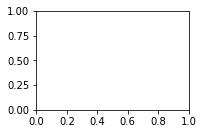

In [37]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["precision"], label="precision")
    plt.plot(history["val_precision"], label="val_precision")
    plt.legend()
    plt.title("Our precision")
    plt.show()
    plt.close()


def compare_histories():
    for training_name, history in history_list.items():
        plt.plot(history["val_binary_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history, history[metric], label='Train')
    plt.plot(history, history['val_'+metric], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();
    plt.show()
    plt.close()

history_list = {}
history_list[model_name] = history.history
render_history(history.history)
plot_metrics(history.history)
compare_histories()

In [13]:
tf.keras.backend.clear_session()

-------------------------
# Predict

-----

## predict on training data

In [38]:
# predict
threshold = 0.3
probabilities = model.predict(tiles)
predictions = [1 if x >= threshold else 0 for x in probabilities]
predictions = np.array(predictions)
# The tiles_info stores: vertical_index, horizontal_index, true label, probability, hor_mean, ver_mean
tile_info[:,3] = probabilities[:,0]

400/400 [==============================] - 3s 7ms/step


In [39]:
def perf_measure(y_actual=tile_info[:,2], y_hat=predictions):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

TP, FP, TN, FN = perf_measure()
print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")

TP: 0, FP: 4038, TN: 8762, FN: 0


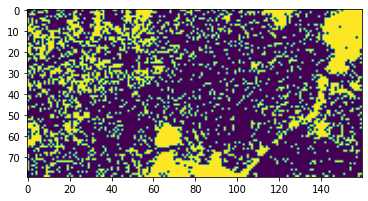

In [40]:
# show labeled tiles
tiles_show = predictions.reshape(num_ver_tiles, num_hor_tiles)
tiles_show[tiles_show == 0] = 0
tiles_show[tiles_show > 0] = 1
plt.imshow(tiles_show)

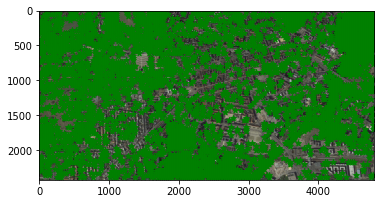

In [41]:
# get pixels for predicted trees
plt.imshow(orig_image)
# plot each labeled tree
for tree in tile_info:
    if tree[3] >= threshold:
        plt.scatter(tree[5], tree[4], marker='*',  c="green")
    #plt.plot(tile[0], tile[1], marker='*', color="green")
plt.show()

Save predictions


In [18]:
# save predictions
np.savetxt(f'predictions_{name_raw_data}_{model}.txt', predictions)

## Test on images

In [19]:
# load the image to get its shape
name_raw_data = "Potsdam_02"
orig_image = load_img(path_raw_data+name_raw_data+'.jpg')
i_width, i_height = orig_image.size
# convert to numpy array
image = img_to_array(orig_image)
# scale pixel values to [0, 1]
image = image.astype('float32')
image /= 255.0

In [20]:
# define the tile size
tile_size = 30
num_horizontal_tiles = i_width // tile_size
num_vertical_tiles = i_height // tile_size
num_tiles = num_horizontal_tiles * num_vertical_tiles
print(f"There are {num_tiles} tiles at {tile_size}x{tile_size} pixels")
print(f"There are {num_horizontal_tiles} horizontal tile columns and {num_vertical_tiles} vertical tile rows")

# prepare variables for the tiles
image = np.array(image) # input image
tiles = np.zeros((num_tiles, tile_size, tile_size, 3)) # all tile images
tile = np.zeros((tile_size, tile_size, 3)) # image of tile
tile_info = np.zeros((num_tiles, 6)) # (tile row, tile column, true_label, probability, x_mean, y_mean)

# create tiles
for i in tq(range(num_vertical_tiles)):
    for j in range(num_horizontal_tiles):
        tile_num = i * num_horizontal_tiles + j
        # give starting (left/top) & mean pixels in rows and columns for this tile
        v_start = i * tile_size
        h_start = j * tile_size
        v_mean = v_start + tile_size // 2
        h_mean = h_start + tile_size // 2
        # create tile
        tile = image[v_start:v_start+tile_size, h_start:h_start+tile_size, :]
        # add tile to array
        tiles[tile_num] = tile
        # store location ot tiles:
        tile_info[tile_num] = (i,j,0,0,v_mean, h_mean)

print(f"Tiles are created: {tiles.shape}.")

There are 12800 tiles at 30x30 pixels
There are 160 horizontal tile columns and 80 vertical tile rows


100%|██████████| 80/80 [00:00<00:00, 450.37it/s]

Tiles are created: (12800, 30, 30, 3).


400/400 [==============================] - 2s 5ms/step


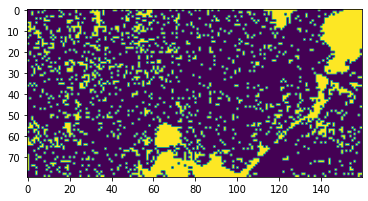

In [21]:
# predict
threshold = 0.3
probabilities = model.predict(tiles)
predictions = [1 if x >= threshold else 0 for x in probabilities]
predictions = np.array(predictions)
# The tiles_info stores: vertical_index, horizontal_index, true label, probability, hor_mean, ver_mean
tile_info[:,3] = probabilities[:,0]
#count true predictions
true_predictions = sum(1 if x == y else 0 for x, y in zip(predictions, tile_labels))
#true_predictions_count = sum(true_predictions)
#print(f"True trees: {tile_count.sum()}")
#print(f"Predictions: {true_predictions_count} out of {len(predictions)} tiles are identified as with trees.")
# show labeled tiles
tiles_show = predictions.reshape(num_vertical_tiles, num_horizontal_tiles)
tiles_show[tiles_show == 0] = 0
tiles_show[tiles_show > 0] = 1
plt.imshow(tiles_show)

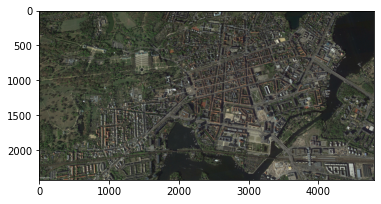

In [22]:
plt.imshow(orig_image)